In [374]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils import setup_plot_style
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path
from ripser import ripser
from persim import plot_diagrams
import gudhi

%load_ext autoreload
%autoreload 2

colors = setup_plot_style()

data_dir = r'D:/data-distance-coding-project/processed-data'
session = r'250313_SAM033_gratings-full'
session_path = os.path.join(data_dir, session)
results_path = os.path.join(session_path, r'results')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [369]:
# show df
def load_data(osi_threshold=0.5, r_squared_threshold=0.6):
    """Load and preprocess neural data."""
    print("Loading and preprocessing data...")
    df = pd.read_csv(os.path.join(results_path, r'cell_properties.csv'))
    
    # Parse string arrays
    df['orientations'] = df['orientations'].apply(lambda s: [float(x) for x in s.strip('[]').split()])
    df['mean_responses'] = df['mean_responses'].apply(lambda s: [float(x) for x in s.strip('[]').split()])

    # Filter cells based on quality metrics
    filtered_df = df[(df['osi'] >= osi_threshold) & (df['r_squared'] >= r_squared_threshold )]
    print(f"Filtered from {len(df)} to {len(filtered_df)} cells based on criteria.")
    
    orientations = np.array(filtered_df['orientations'].iloc[0])
    responses = np.zeros((len(filtered_df), len(orientations)))
    for i, resp in enumerate(filtered_df['mean_responses']):
        responses[i] = np.array(resp)
    
    return orientations, responses

In [370]:
orientations, responses = load_data(osi_threshold=0.5, r_squared_threshold=0.6)

print('Number of cells: ', np.shape(responses)[0])
print('Number of orientations: ', np.shape(responses)[1])

Loading and preprocessing data...
Filtered from 558 to 449 cells based on criteria.
Number of cells:  449
Number of orientations:  18


## Pre-process data

In [73]:
# Z-score the orientation responses for each cell (row-wise normalization)
def z_score_responses(responses):
    """
    Z-score the responses for each cell (row-wise normalization).
    
    Parameters:
    -----------
    responses : ndarray
        Matrix where each row represents a cell and each column represents 
        the response to a specific orientation
    
    Returns:
    --------
    z_scored_responses : ndarray
        Z-scored response matrix
    """
    # Calculate mean and standard deviation for each cell (row)
    means = np.mean(responses, axis=1, keepdims=True)
    stds = np.std(responses, axis=1, keepdims=True)
    
    # Handle cases where standard deviation is zero to avoid division by zero
    stds[stds == 0] = 1.0
    
    # Z-score the data
    z_scored_responses = (responses - means) / stds
    
    return z_scored_responses

# Apply z-scoring to the orientation responses
response_matrix = z_score_responses(responses)
print(f"Shape of z-scored response matrix: {response_matrix.shape}")
print(f"Z-scoring complete: Each cell's responses now have mean=0 and std=1")


Shape of z-scored response matrix: (449, 18)
Z-scoring complete: Each cell's responses now have mean=0 and std=1


# Dimensionality Reduction


## With PCA

5


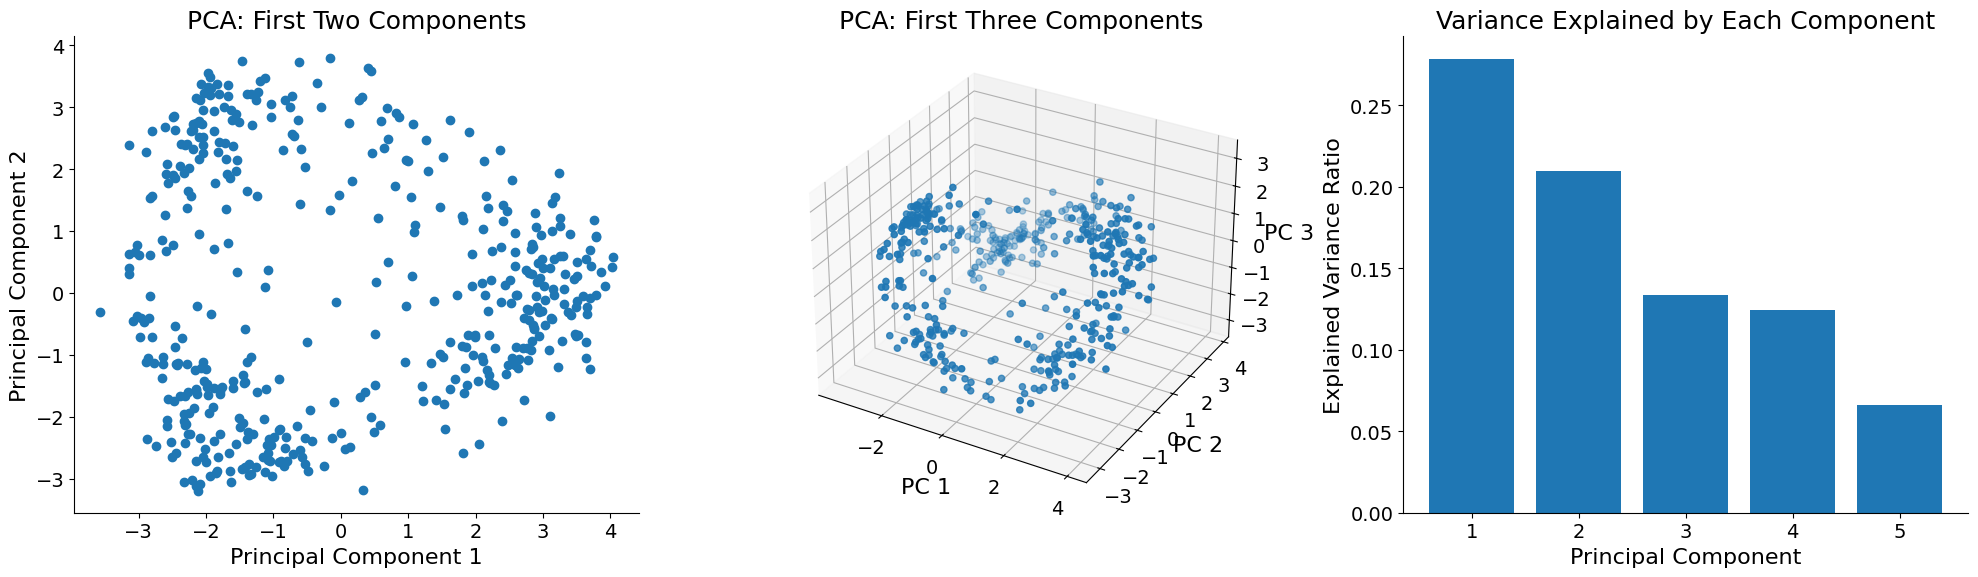

In [85]:
# Keep the PCA analysis
pca = PCA(n_components=5)
data_reduced = pca.fit_transform(response_matrix)

print(pca.n_components_)

# Create a figure with three subplots
fig = plt.figure(figsize=(20, 6))  # Increased width from 15 to 20

# First subplot: 2D PCA
ax1 = fig.add_subplot(131)
ax1.scatter(data_reduced[:,0], data_reduced[:,1])
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('PCA: First Two Components')

# Second subplot: 3D PCA
from mpl_toolkits.mplot3d import Axes3D
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(data_reduced[:, 0], data_reduced[:, 1], data_reduced[:, 2])
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_zlabel('PC 3')
ax2.set_title('PCA: First Three Components')

# Third subplot: Explained variance
ax3 = fig.add_subplot(133)
explained_variance = pca.explained_variance_ratio_
components = range(1, len(explained_variance) + 1)
ax3.bar(components, explained_variance)
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained Variance Ratio')
ax3.set_title('Variance Explained by Each Component')

plt.tight_layout()
plt.show()

## UMAP dimensionality reduction

Loading and preprocessing data...
Filtered from 558 to 507 cells based on criteria.


c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP dimensions: 3


Text(0.5, 1.0, 'UMAP: First Two Components')

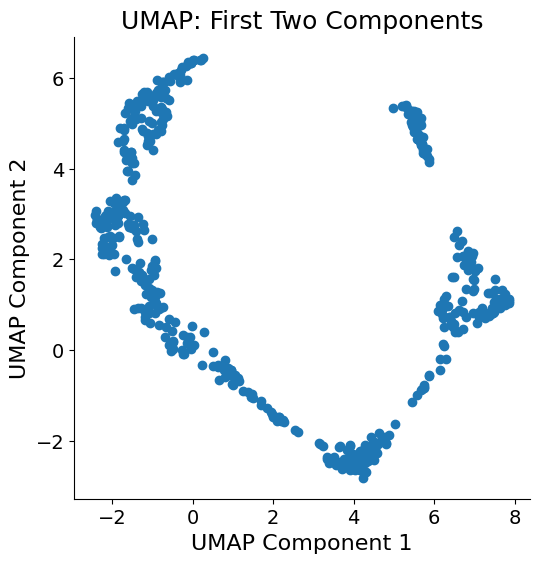

In [ ]:
# Use UMAP for dimensionality reduction
orientations, responses = load_data(osi_threshold=0.5, r_squared_threshold=0.0)
response_matrix = z_score_responses(responses)

n_components = 3

fit = umap.UMAP(
    n_components=n_components,
    n_neighbors=30,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)

# # Apply UMAP to the data
data_reduced = fit.fit_transform(response_matrix)

print(f"UMAP dimensions: {n_components}")

# Create a figure with two subplots
fig = plt.figure(figsize=(20, 6))

# First subplot: 2D UMAP
ax1 = fig.add_subplot(131)
ax1.scatter(data_reduced[:,0], data_reduced[:,1])
ax1.set_xlabel('UMAP Component 1')
ax1.set_ylabel('UMAP Component 2')
ax1.set_title('UMAP: First Two Components')

## Trying different umap metrics

Loading and preprocessing data...
Filtered from 558 to 449 cells based on criteria.


c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


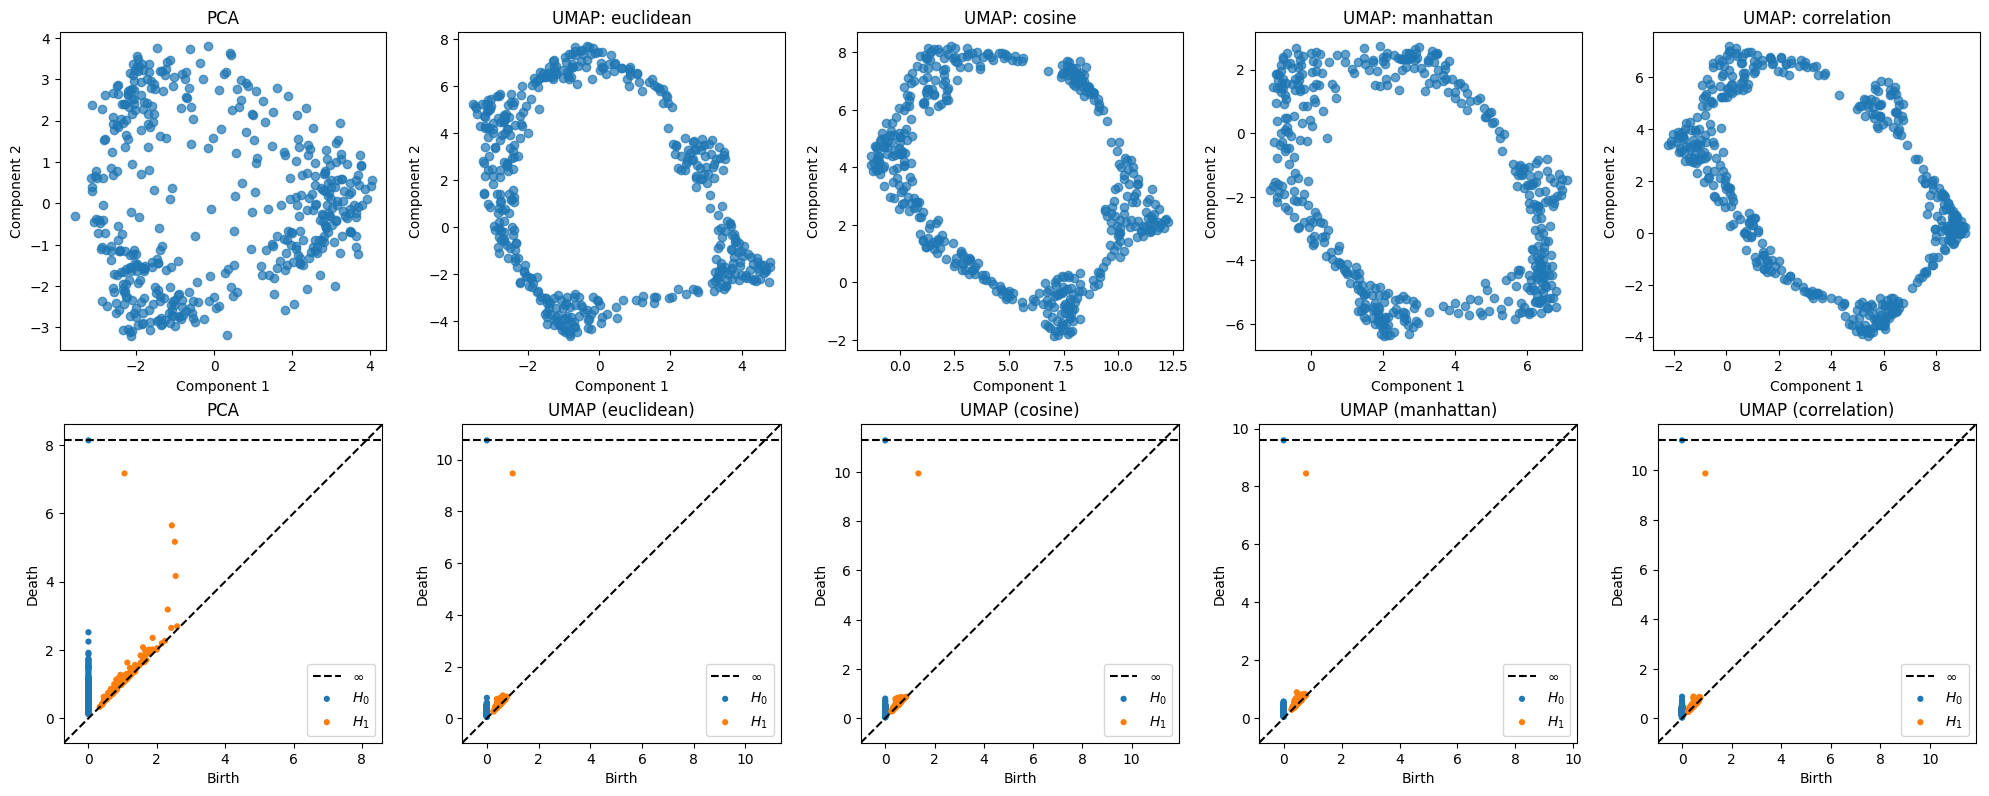

In [373]:
# Use UMAP for dimensionality reduction
orientations, responses = load_data(osi_threshold=0.5, r_squared_threshold=0.6)
response_matrix = z_score_responses(responses)

# make a plot to compare pca with umap of different metrics
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Compare PCA and UMAP with different distance metrics
metrics = ['euclidean', 'cosine', 'manhattan', 'correlation']

# First row for PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(response_matrix)

# Plot PCA in first row
axs[0, 0].scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
axs[0, 0].set_title('PCA')
axs[0, 0].set_ylabel('Component 2')
axs[0, 0].set_xlabel('Component 1')

# Define a function to compute persistence diagrams
def compute_persistence(data, title, ax_diagram=None, ax_barcode=None):
    # Create a k-nearest neighbors graph
    k = min(15, len(data) - 1)  # Choose appropriate k
    knn_graph = kneighbors_graph(data, n_neighbors=k, mode='distance')
    
    # Compute the shortest path through the graph (geodesic distances)
    distances_matrix = shortest_path(knn_graph, directed=False)
    
    # Compute persistence diagrams
    diagrams = ripser(distances_matrix, distance_matrix=True, maxdim=1)['dgms']
    
    # Plot persistence diagram if axis is provided
    if ax_diagram is not None:
        # Only plot H1 (dimension 1)
        plot_diagrams(diagrams, ax=ax_diagram, show=False)
        ax_diagram.set_title(f'{title}')
    
    return diagrams

# Analyze PCA results
pca_diagrams = compute_persistence(pca_result, "PCA", ax_diagram=axs[1, 0])

# Compute and analyze UMAP with different metrics
for i, metric in enumerate(metrics):
    # UMAP with current metric
    umap_model = umap.UMAP(
        n_components=3,
        n_neighbors=30,
        min_dist=0.38,
        metric=metric,
        random_state=42
    )
    umap_result = umap_model.fit_transform(response_matrix)
    
    # Plot UMAP in respective column (first row)
    ax = axs[0, i+1]
    ax.scatter(umap_result[:, 0], umap_result[:, 1], alpha=0.7)
    ax.set_title(f'UMAP: {metric}')
    ax.set_ylabel('Component 2')
    ax.set_xlabel('Component 1')
    
    # Compute persistence for this UMAP embedding (second row)
    umap_diagrams = compute_persistence(umap_result, f"UMAP ({metric})", ax_diagram=axs[1, i+1])

plt.tight_layout()
plt.show()

Loading and preprocessing data...
Filtered from 558 to 449 cells based on criteria.


c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


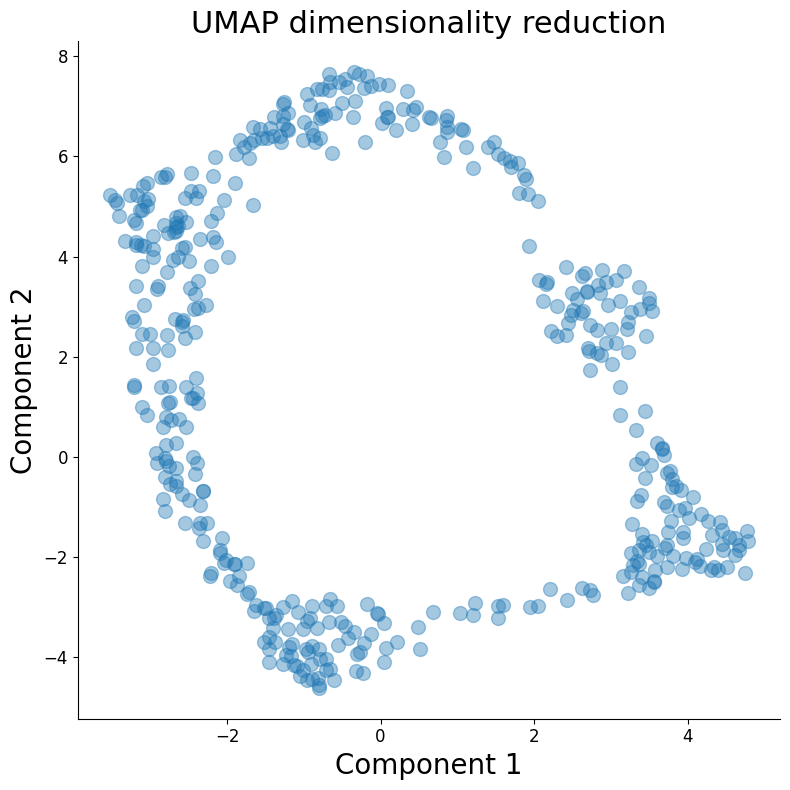

In [366]:
# Use UMAP for dimensionality reduction with euclidean metric
orientations, responses = load_data(osi_threshold=0.5, r_squared_threshold=0.6)
response_matrix = z_score_responses(responses)

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 8))

# UMAP with euclidean metric
umap_model = umap.UMAP(
    n_components=3,
    n_neighbors=30,
    min_dist=0.38,
    metric='euclidean',
    random_state=42
)
umap_result = umap_model.fit_transform(response_matrix)

# Plot UMAP
ax.scatter(umap_result[:, 0], umap_result[:, 1], s=100, alpha=0.4)
ax.set_title('UMAP dimensionality reduction', fontsize=22)
ax.set_ylabel('Component 2', fontsize=20)
ax.set_xlabel('Component 1', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)

# remove splines top and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

c:\Users\acostamendoza\.virtualenvs\Distance-Coding-Analysis\Lib\site-packages\gudhi\persistence_graphical_tools.py:107: UserWarning: There are 566 intervals given as input, whereas max_intervals is set to 30.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

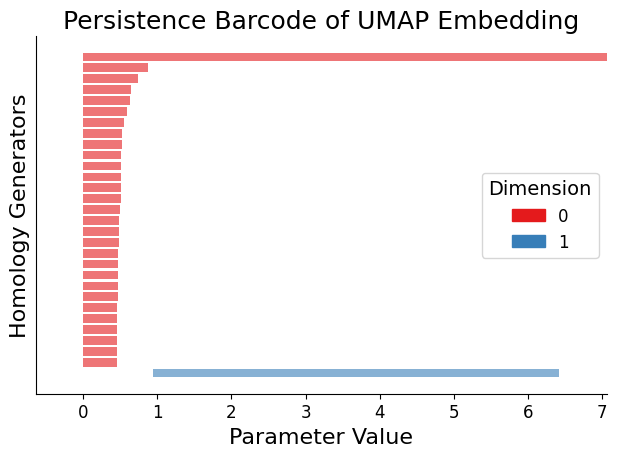

In [375]:
# Use the UMAP embedding instead of external data
point_cloud = umap_result

# Create Rips complex from the UMAP embedding
rips_complex = gudhi.RipsComplex(points=point_cloud)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()

# Create a figure for the barcode plot
plt.figure(figsize=(8, 8))
gudhi.plot_persistence_barcode(diag, max_intervals=30, inf_delta=0.1)
plt.title('Persistence Barcode of UMAP Embedding', fontsize=18)
plt.xlabel('Parameter Value', fontsize=16)
plt.ylabel('Homology Generators', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

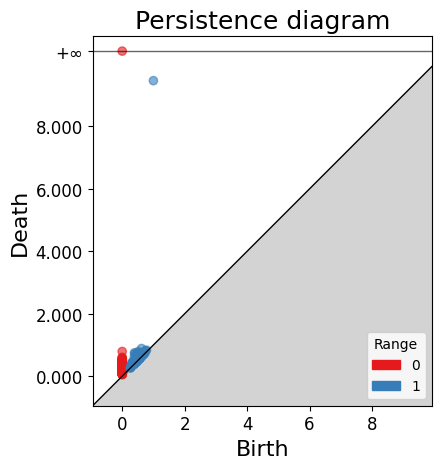

In [363]:
import matplotlib.pyplot as plt
import gudhi

umap_diagrams = compute_persistence(umap_result, "Persistence Diagram", ax_diagram=axs[1])
# Use the persistence diagram from our UMAP embedding
diag = simplex_tree.persistence()

# Plot the persistence diagram
plt.figure(figsize=(8, 8))
ax = gudhi.plot_persistence_diagram(umap_diagrams)
# Customize the plot
ax.set_title("Persistence diagram", fontsize=18)
ax.set_xlabel("Birth", fontsize=16)
ax.set_ylabel("Death", fontsize=16)
ax.set_aspect("equal")  # forces to be square shaped
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

## Truing Vietoris rips plots -- not looking good

<Axes: title={'center': 'Vietoris-Rips Complex (Radius = 1.00)'}>

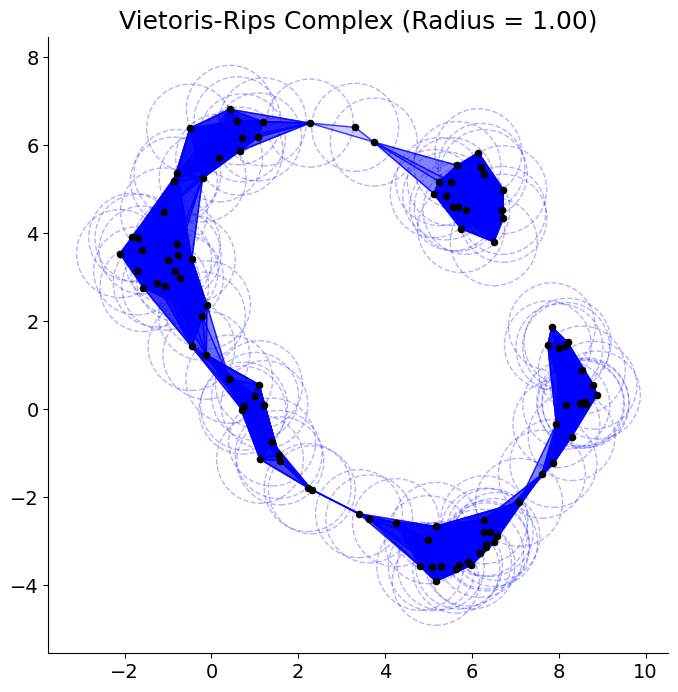

In [376]:
random_seed = 42

# Create function to visualize the Vietoris-Rips complex at different radius values in 2D
def plot_vietoris_rips_at_radius(points, radius, ax=None, color='blue', alpha=0.3):
    """Plot the Vietoris-Rips complex at a given radius in 2D."""
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = plt.gca()

    # Use a subset of points for better visualization
    np.random.seed(random_seed)  # Use the random_seed defined earlier
    if len(points) > 100:
        sampled_indices = np.random.choice(len(points), 100, replace=False)
        points = points[sampled_indices]
    
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], c='black', s=20, zorder=10)
    
    # Calculate pairwise distances between points
    distances = squareform(pdist(points[:, :2]))
    
    # Draw edges between points that are within radius of each other
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            if distances[i, j] <= 2 * radius:  # If points are close enough to connect
                ax.plot([points[i, 0], points[j, 0]], 
                        [points[i, 1], points[j, 1]], 
                        color=color, alpha=0.7, linewidth=1, zorder=5)
    
    # Create a list to store triangles (2-simplices)
    triangles = []
    
    # Find all 2-simplices (triangles)
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            if distances[i, j] <= 2 * radius:
                for k in range(j+1, len(points)):
                    if (distances[i, k] <= 2 * radius and 
                        distances[j, k] <= 2 * radius):
                        # All three points are within radius of each other
                        triangles.append([i, j, k])
    
    # Plot the triangles (2-simplices)
    for triangle in triangles:
        i, j, k = triangle
        triangle_points = np.array([points[i], points[j], points[k]])
        ax.fill(triangle_points[:, 0], triangle_points[:, 1], 
                color=color, alpha=0.2, zorder=1)
    
    # Plot circles at each point
    for i in range(len(points)):
        circle = plt.Circle((points[i, 0], points[i, 1]), radius, 
                           color=color, fill=False, alpha=0.3, linestyle='--')
        ax.add_patch(circle)
    
    ax.set_title(f'Vietoris-Rips Complex (Radius = {radius:.2f})')
    return ax

# Create a more detailed visualization
plot_vietoris_rips_at_radius(umap_result, 1, ax=None, color='blue', alpha=0.3)